In [9]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                            classification_report, precision_recall_fscore_support)
from sklearn.model_selection import GridSearchCV

try:
    from mlxtend.plotting import plot_decision_regions
except ImportError:
    print("mlxtend not found. Using alternative decision boundary plotting method.")
    # Define a simple alternative for decision boundary plotting
    def plot_decision_regions(X, y, clf, ax=None, **kwargs):
        if ax is None:
            ax = plt.gca()
            
        # Create mesh grid
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                             np.arange(y_min, y_max, 0.1))
        
        # Predict for each point in mesh grid
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        ax.contourf(xx, yy, Z, alpha=0.4)
        ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
        return ax

# Set style for better visualizations
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

mlxtend not found. Using alternative decision boundary plotting method.


In [10]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Create a comprehensive DataFrame
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['target'] = y
iris_df['species'] = iris_df['target'].map({0: target_names[0], 
                                          1: target_names[1], 
                                          2: target_names[2]})

# Exploratory Data Analysis
print("\n=== Dataset Overview ===")
print(f"Number of samples: {len(iris_df)}")
print(f"Number of features: {len(feature_names)}")
print("\nFeature names:", feature_names)
print("\nTarget names:", target_names)
print("\nClass distribution:")
print(iris_df['species'].value_counts())



=== Dataset Overview ===
Number of samples: 150
Number of features: 4

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target names: ['setosa' 'versicolor' 'virginica']

Class distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


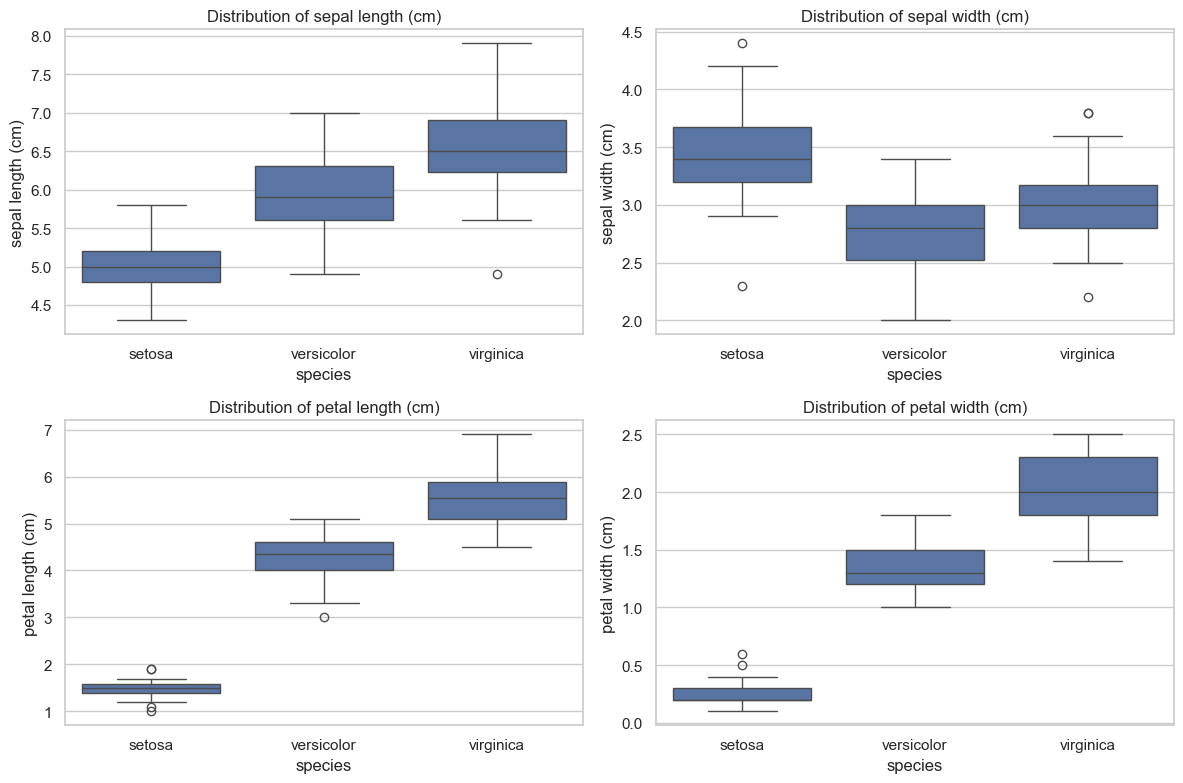


=== Data Splits ===
Training samples: 105
Testing samples: 45


In [11]:
# Visualize feature distributions
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='species', y=feature, data=iris_df)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

# Data Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print("\n=== Data Splits ===")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")



=== Hyperparameter Tuning Results ===
Best parameters: {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9714


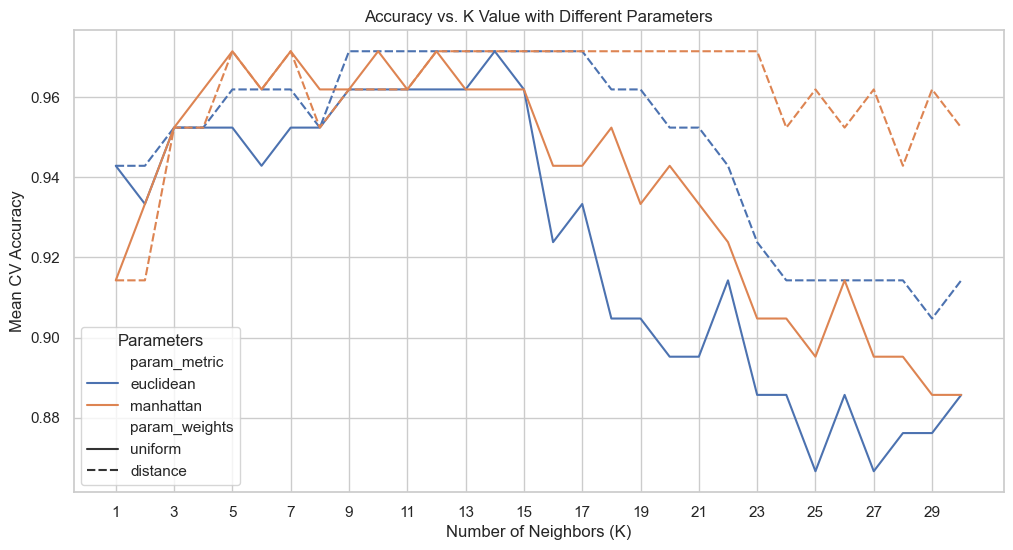

In [12]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\n=== Hyperparameter Tuning Results ===")
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

# Plot accuracy vs K values
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(12, 6))
sns.lineplot(data=results, x='param_n_neighbors', y='mean_test_score', 
             hue='param_metric', style='param_weights')
plt.title('Accuracy vs. K Value with Different Parameters')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean CV Accuracy')
plt.xticks(np.arange(1, 31, 2))
plt.legend(title='Parameters')
plt.savefig('hyperparameter_tuning.png')
plt.show()


=== Model Evaluation ===
Test Accuracy: 0.9556
Precision: 0.9608
Recall: 0.9556
F1 Score: 0.9554

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      1.00      0.94        15
   virginica       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



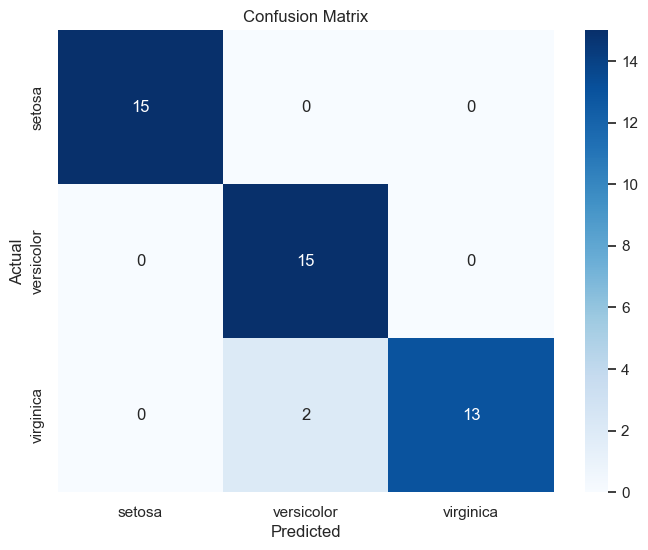

C:\Users\mils0\AppData\Local\Temp\ipykernel_26984\1269462102.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T,


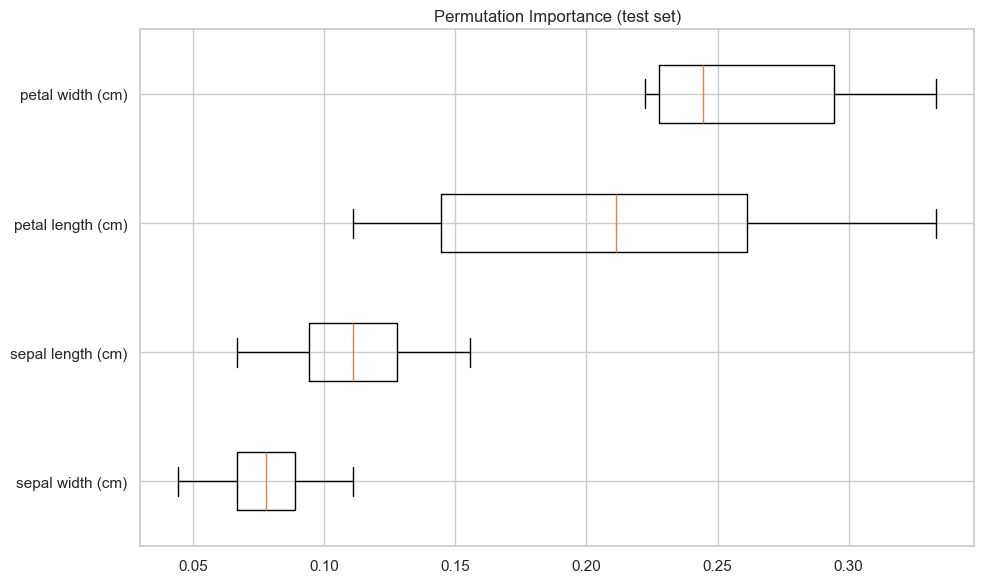

In [13]:
# Train final model with best parameters
final_knn = grid_search.best_estimator_
final_knn.fit(X_train, y_train)

# Model Evaluation
y_pred = final_knn.predict(X_test)
y_pred_proba = final_knn.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print("\n=== Model Evaluation ===")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')
plt.show()

# Feature Importance Analysis (permutation importance)
from sklearn.inspection import permutation_importance

result = permutation_importance(
    final_knn, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

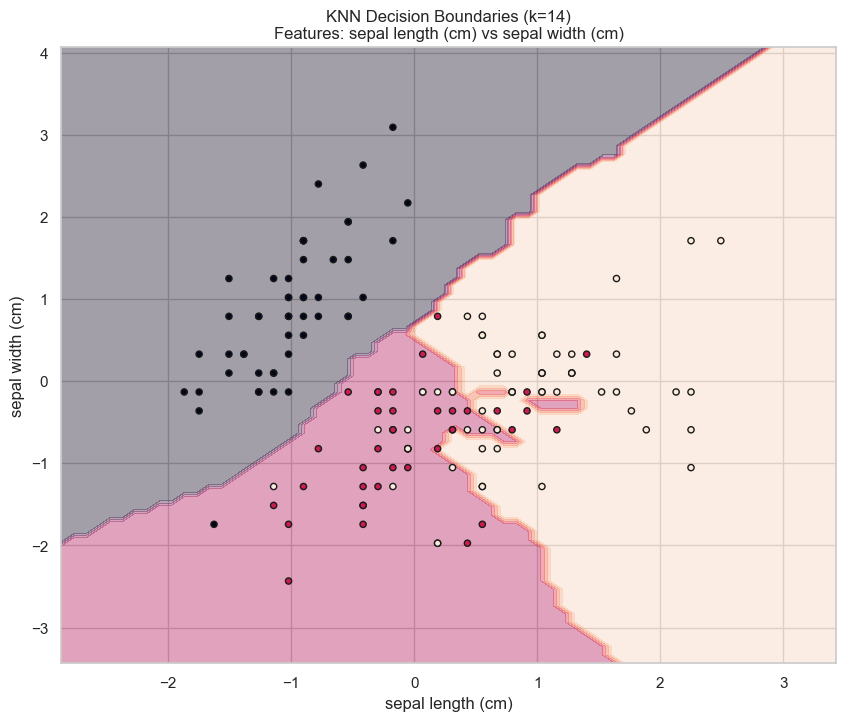

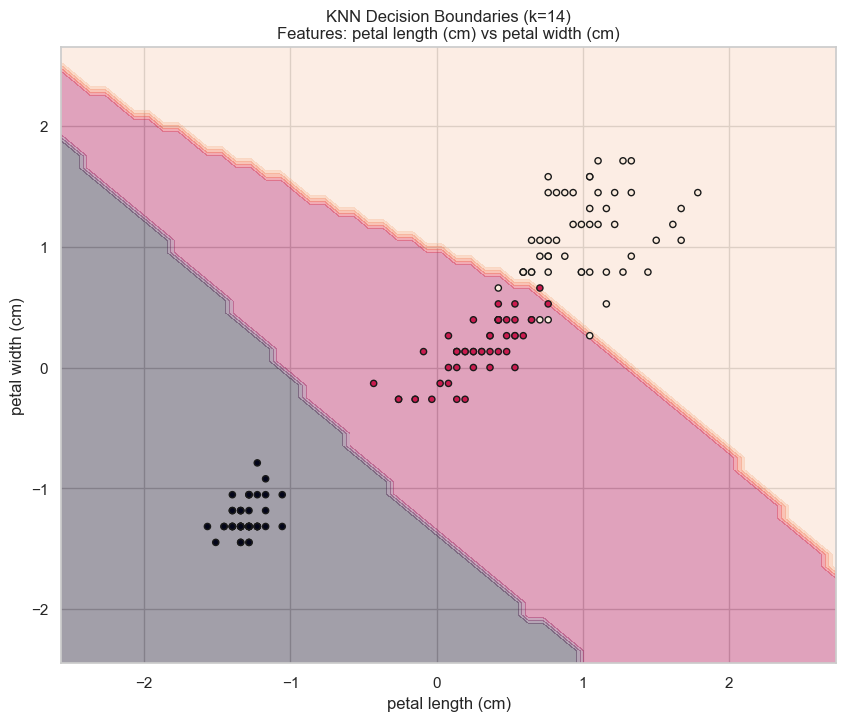

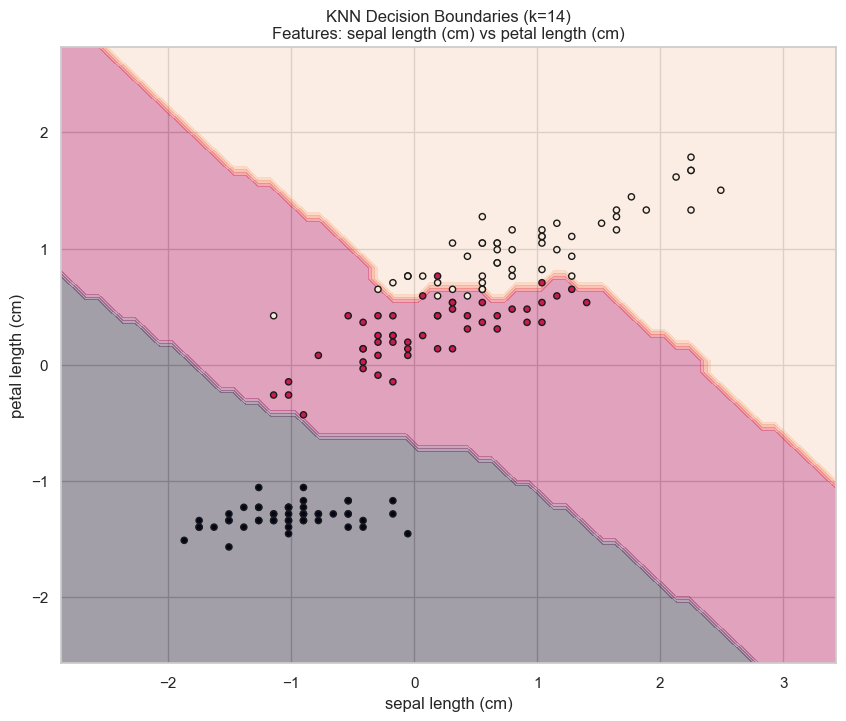

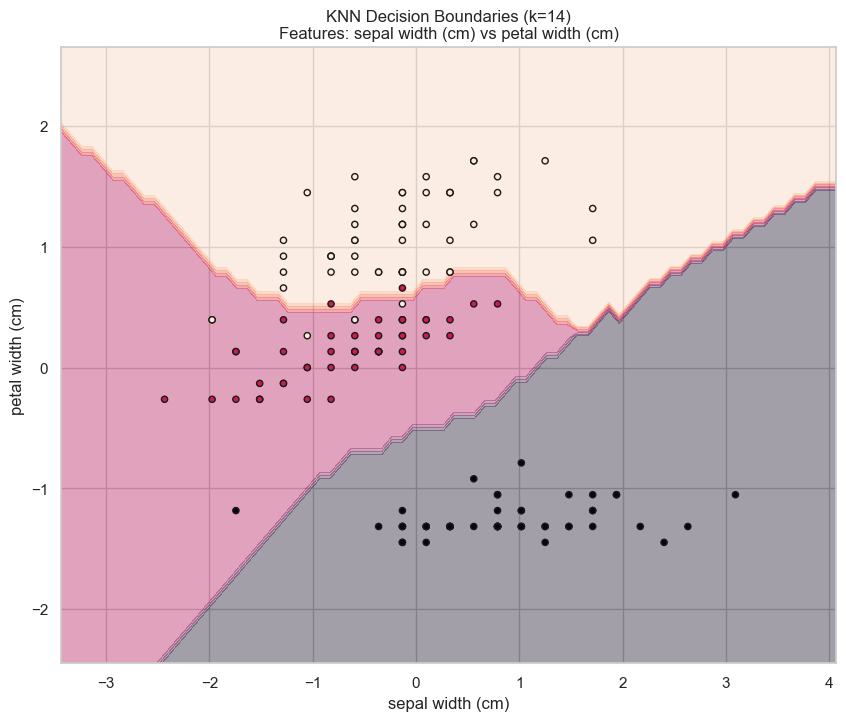

In [14]:
# Decision Boundaries Visualization (for 2 features)
def plot_decision_boundaries_2d(X, y, feature1, feature2, model, title):
    X_2d = X[:, [feature1, feature2]]
    model.fit(X_2d, y)
    
    plt.figure(figsize=(10, 8))
    plot_decision_regions(X_2d, y, clf=model, legend=2)
    plt.xlabel(feature_names[feature1])
    plt.ylabel(feature_names[feature2])
    plt.title(title)
    plt.savefig(f'decision_boundaries_{feature_names[feature1]}_{feature_names[feature2]}.png')
    plt.show()

# Plot for different feature combinations
feature_pairs = [(0, 1), (2, 3), (0, 2), (1, 3)]
for pair in feature_pairs:
    plot_decision_boundaries_2d(
        X_scaled, y, pair[0], pair[1], 
        KNeighborsClassifier(**best_params),
        f'KNN Decision Boundaries (k={best_params["n_neighbors"]})\nFeatures: {feature_names[pair[0]]} vs {feature_names[pair[1]]}'
    )

# Save model metrics to file
with open('model_metrics.txt', 'w') as f:
    f.write(f"Best Parameters: {best_params}\n")
    f.write(f"Best CV Accuracy: {best_score:.4f}\n")
    f.write(f"Test Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=target_names))